# Convolutional Autoencoder

Sticking with the MNIST dataset, let's improve our autoencoder's performance using convolutional layers. Again, loading modules and the data.

In [10]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [11]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', validation_size=0)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


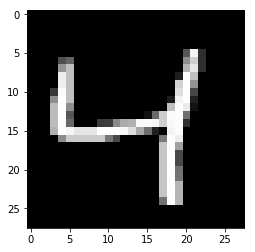

In [12]:
img = mnist.train.images[2]
plt.imshow(img.reshape((28, 28)), cmap='Greys_r')

## Network Architecture

The encoder part of the network will be a typical convolutional pyramid. Each convolutional layer will be followed by a max-pooling layer to reduce the dimensions of the layers. The decoder though might be something new to you. The decoder needs to convert from a narrow representation to a wide reconstructed image. For example, the representation could be a 4x4x8 max-pool layer. This is the output of the encoder, but also the input to the decoder. We want to get a 28x28x1 image out from the decoder so we need to work our way back up from the narrow decoder input layer. A schematic of the network is shown below.

<img src='assets/convolutional_autoencoder.png' width=500px>

Here our final encoder layer has size 4x4x8 = 128. The original images have size 28x28 = 784, so the encoded vector is roughly 16% the size of the original image. These are just suggested sizes for each of the layers. Feel free to change the depths and sizes, but remember our goal here is to find a small representation of the input data.

### What's going on with the decoder

Okay, so the decoder has these "Upsample" layers that you might not have seen before. First off, I'll discuss a bit what these layers *aren't*. Usually, you'll see **transposed convolution** layers used to increase the width and height of the layers. They work almost exactly the same as convolutional layers, but in reverse. A stride in the input layer results in a larger stride in the transposed convolution layer. For example, if you have a 3x3 kernel, a 3x3 patch in the input layer will be reduced to one unit in a convolutional layer. Comparatively, one unit in the input layer will be expanded to a 3x3 path in a transposed convolution layer. The TensorFlow API provides us with an easy way to create the layers, [`tf.nn.conv2d_transpose`](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d_transpose). 

However, transposed convolution layers can lead to artifacts in the final images, such as checkerboard patterns. This is due to overlap in the kernels which can be avoided by setting the stride and kernel size equal. In [this Distill article](http://distill.pub/2016/deconv-checkerboard/) from Augustus Odena, *et al*, the authors show that these checkerboard artifacts can be avoided by resizing the layers using nearest neighbor or bilinear interpolation (upsampling) followed by a convolutional layer. In TensorFlow, this is easily done with [`tf.image.resize_images`](https://www.tensorflow.org/versions/r1.1/api_docs/python/tf/image/resize_images), followed by a convolution. Be sure to read the Distill article to get a better understanding of deconvolutional layers and why we're using upsampling.

> **Exercise:** Build the network shown above. Remember that a convolutional layer with strides of 1 and 'same' padding won't reduce the height and width. That is, if the input is 28x28 and the convolution layer has stride = 1 and 'same' padding, the convolutional layer will also be 28x28. The max-pool layers are used the reduce the width and height. A stride of 2 will reduce the size by a factor of 2. Odena *et al* claim that nearest neighbor interpolation works best for the upsampling, so make sure to include that as a parameter in `tf.image.resize_images` or use [`tf.image.resize_nearest_neighbor`]( `https://www.tensorflow.org/api_docs/python/tf/image/resize_nearest_neighbor). For convolutional layers, use [`tf.layers.conv2d`](https://www.tensorflow.org/api_docs/python/tf/layers/conv2d). For example, you would write `conv1 = tf.layers.conv2d(inputs, 32, (5,5), padding='same', activation=tf.nn.relu)` for a layer with a depth of 32, a 5x5 kernel, stride of (1,1), padding is 'same', and a ReLU activation. Similarly, for the max-pool layers, use [`tf.layers.max_pooling2d`](https://www.tensorflow.org/api_docs/python/tf/layers/max_pooling2d).

In [25]:
learning_rate = 0.001
# Input and target placeholders
inputs_ = tf.placeholder(dtype=tf.float32, shape=(None, 28, 28, 1))
targets_ = tf.placeholder(dtype=tf.float32, shape=(None, 28, 28, 1))

### Encoder
conv1 = tf.layers.conv2d(inputs=inputs_, filters=16, kernel_size=(5, 5), padding='same',
                         activation=tf.nn.relu)
# Now 28x28x16
maxpool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=2, strides=2)
# Now 14x14x16
conv2 = tf.layers.conv2d(inputs=maxpool1, filters=8, kernel_size=(3, 3), padding='same',
                         activation=tf.nn.relu)
# Now 14x14x8
maxpool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=2, strides=2)
# Now 7x7x8
conv3 = tf.layers.conv2d(inputs=maxpool2, filters=8, kernel_size=(3, 3), padding='same',
                         activation=tf.nn.relu)
# Now 7x7x8
encoded = tf.layers.max_pooling2d(inputs=conv3, pool_size=4, strides=1)
# Now 4x4x8

### Decoder
upsample1 = tf.image.resize_nearest_neighbor(images=encoded, size=(7,7))
# Now 7x7x8
conv4 = tf.layers.conv2d(inputs=upsample1, filters=8, kernel_size=(3, 3), padding='same',
                         activation=tf.nn.relu)
# Now 7x7x8
upsample2 = tf.image.resize_nearest_neighbor(images=conv4, size=(14,14))
# Now 14x14x8
conv5 = tf.layers.conv2d(inputs=upsample2, filters=8, kernel_size=(3, 3), padding='same',
                         activation=tf.nn.relu)
# Now 14x14x8
upsample3 = tf.image.resize_nearest_neighbor(images=conv5, size=(28,28))
# Now 28x28x8
conv6 = tf.layers.conv2d(inputs=upsample3, filters=16, kernel_size=(5, 5), padding='same',
                         activation=tf.nn.relu)
# Now 28x28x16

logits = tf.layers.conv2d(inputs=conv6, filters=1, kernel_size=(1, 1), padding='same',
                         activation=None)
#Now 28x28x1

# Pass logits through sigmoid to get reconstructed image
decoded = tf.sigmoid(logits)

# Pass logits through sigmoid and calculate the cross-entropy loss
loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=targets_, logits=logits)

# Get cost and define the optimizer
cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(learning_rate).minimize(cost)

## Training

As before, here we'll train the network. Instead of flattening the images though, we can pass them in as 28x28x1 arrays.

In [4]:
sess = tf.Session()

In [5]:
epochs = 20
batch_size = 200
sess.run(tf.global_variables_initializer())
for e in range(epochs):
    for ii in range(mnist.train.num_examples//batch_size):
        batch = mnist.train.next_batch(batch_size)
        imgs = batch[0].reshape((-1, 28, 28, 1))
        batch_cost, _ = sess.run([cost, opt], feed_dict={inputs_: imgs,
                                                         targets_: imgs})

        print("Epoch: {}/{}...".format(e+1, epochs),
              "Training loss: {:.4f}".format(batch_cost))

NameError: name 'cost' is not defined

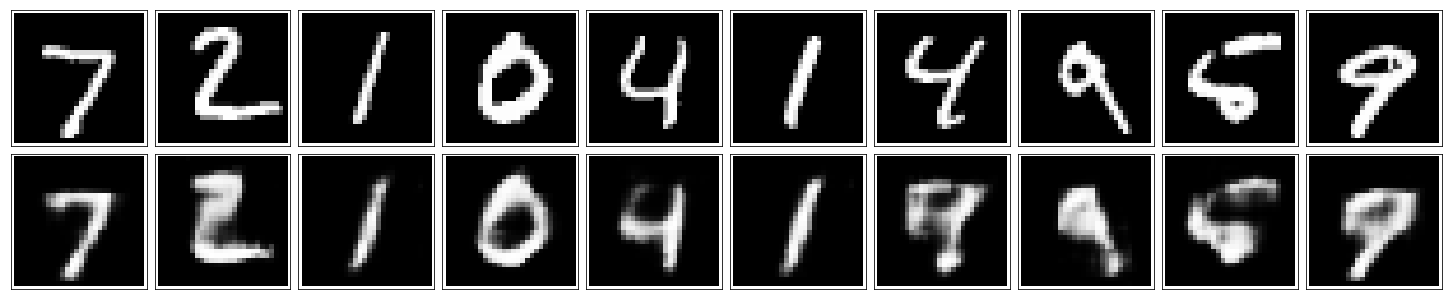

In [28]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = mnist.test.images[:10]
reconstructed = sess.run(decoded, feed_dict={inputs_: in_imgs.reshape((10, 28, 28, 1))})

for images, row in zip([in_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


fig.tight_layout(pad=0.1)

In [9]:
sess.close()

## Denoising

As I've mentioned before, autoencoders like the ones you've built so far aren't too useful in practive. However, they can be used to denoise images quite successfully just by training the network on noisy images. We can create the noisy images ourselves by adding Gaussian noise to the training images, then clipping the values to be between 0 and 1. We'll use noisy images as input and the original, clean images as targets. Here's an example of the noisy images I generated and the denoised images.

![Denoising autoencoder](assets/denoising.png)


Since this is a harder problem for the network, we'll want to use deeper convolutional layers here, more feature maps. I suggest something like 32-32-16 for the depths of the convolutional layers in the encoder, and the same depths going backward through the decoder. Otherwise the architecture is the same as before.

> **Exercise:** Build the network for the denoising autoencoder. It's the same as before, but with deeper layers. I suggest 32-32-16 for the depths, but you can play with these numbers, or add more layers.

In [13]:
learning_rate = 0.001
inputs_ = tf.placeholder(tf.float32, (None, 28, 28, 1), name='inputs')
targets_ = tf.placeholder(tf.float32, (None, 28, 28, 1), name='targets')

### Encoder
conv1 = tf.layers.conv2d(inputs=inputs_, filters=32, kernel_size=(4,4), strides=2,
                        activation=tf.nn.relu)
paddings = tf.constant([[0, 0],[1, 1], [1, 1], [0,0]])
pad1 = tf.pad(conv1, paddings)
# Now 14x14x32
conv2 = tf.layers.conv2d(inputs=pad1, filters=32, kernel_size=(2,2), strides=2,
                        activation=tf.nn.relu)
pad2 = tf.pad(conv2, paddings=tf.constant([[0,0],[1,1],[1,1],[0,0]]))
# Now 7x7x32
conv3 = tf.layers.conv2d(inputs=pad2, filters=16, kernel_size=(1,1), strides=1, padding='same',
                        activation=tf.nn.relu)
# Now 7x7x16
encoded = tf.layers.max_pooling2d(inputs=conv3, pool_size=4, strides=1)
# Now 4x4x16

### Decoder
upsample1 = tf.image.resize_nearest_neighbor(images=encoded, size=(7,7))
# Now 7x7x16
conv4 = tf.layers.conv2d(inputs=upsample1, filters=16, kernel_size=(3, 3), padding='same',
                         activation=tf.nn.relu)
# Now 7x7x16
upsample2 = tf.image.resize_nearest_neighbor(images=conv4, size=(14,14))
# Now 14x14x16
conv5 = tf.layers.conv2d(inputs=upsample2, filters=32, kernel_size=(3, 3), padding='same',
                         activation=tf.nn.relu)
# Now 14x14x32
upsample3 = tf.image.resize_nearest_neighbor(images=conv5, size=(28,28))
# Now 28x28x32
conv6 = tf.layers.conv2d(inputs=upsample3, filters=32, kernel_size=(3, 3), padding='same',
                         activation=tf.nn.relu)
# Now 28x28x32

logits = tf.layers.conv2d(inputs=conv6, filters=1, kernel_size=(1, 1), padding='same',
                         activation=None)
#Now 28x28x1

# Pass logits through sigmoid to get reconstructed image
decoded = tf.sigmoid(logits)

# Pass logits through sigmoid and calculate the cross-entropy loss
loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=targets_, logits=logits)

# Get cost and define the optimizer
cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(learning_rate).minimize(cost)

In [15]:
#sess = tf.Session()
#with sess.as_default():
#    t = tf.ones(shape=(2, 3, 3, 1), dtype = tf.int16)
#    print(t.shape)
#    paddings = tf.constant([[0, 0],[1, 1], [1, 1], [0,0]])
#    print(tf.pad(t, paddings, "CONSTANT").eval()[0,...,0])



In [16]:
sess = tf.Session()

In [17]:
epochs = 20
batch_size = 200
# Set's how much noise we're adding to the MNIST images
noise_factor = 0.5
sess.run(tf.global_variables_initializer())
for e in range(epochs):
    for ii in range(mnist.train.num_examples//batch_size):
        batch = mnist.train.next_batch(batch_size)
        # Get images from the batch
        imgs = batch[0].reshape((-1, 28, 28, 1))
        
        # Add random noise to the input images
        noisy_imgs = imgs + noise_factor * np.random.randn(*imgs.shape)
        # Clip the images to be between 0 and 1
        noisy_imgs = np.clip(noisy_imgs, 0., 1.)
        
        # Noisy images as inputs, original images as targets
        batch_cost, _ = sess.run([cost, opt], feed_dict={inputs_: noisy_imgs,
                                                         targets_: imgs})

        print("Epoch: {}/{}...".format(e+1, epochs),
              "Training loss: {:.4f}".format(batch_cost))

Epoch: 1/20... Training loss: 0.7057
Epoch: 1/20... Training loss: 0.6923
Epoch: 1/20... Training loss: 0.6839
Epoch: 1/20... Training loss: 0.6764
Epoch: 1/20... Training loss: 0.6675
Epoch: 1/20... Training loss: 0.6558
Epoch: 1/20... Training loss: 0.6411
Epoch: 1/20... Training loss: 0.6212
Epoch: 1/20... Training loss: 0.6012
Epoch: 1/20... Training loss: 0.5740
Epoch: 1/20... Training loss: 0.5431
Epoch: 1/20... Training loss: 0.5209
Epoch: 1/20... Training loss: 0.4952
Epoch: 1/20... Training loss: 0.4917
Epoch: 1/20... Training loss: 0.4962
Epoch: 1/20... Training loss: 0.5317
Epoch: 1/20... Training loss: 0.5285
Epoch: 1/20... Training loss: 0.4896
Epoch: 1/20... Training loss: 0.4956
Epoch: 1/20... Training loss: 0.4828
Epoch: 1/20... Training loss: 0.4845
Epoch: 1/20... Training loss: 0.4836
Epoch: 1/20... Training loss: 0.4875
Epoch: 1/20... Training loss: 0.4738
Epoch: 1/20... Training loss: 0.4767
Epoch: 1/20... Training loss: 0.4701
Epoch: 1/20... Training loss: 0.4703
E

Epoch: 1/20... Training loss: 0.2283
Epoch: 1/20... Training loss: 0.2341
Epoch: 1/20... Training loss: 0.2354
Epoch: 1/20... Training loss: 0.2304
Epoch: 1/20... Training loss: 0.2301
Epoch: 1/20... Training loss: 0.2292
Epoch: 1/20... Training loss: 0.2238
Epoch: 1/20... Training loss: 0.2303
Epoch: 1/20... Training loss: 0.2276
Epoch: 1/20... Training loss: 0.2257
Epoch: 1/20... Training loss: 0.2366
Epoch: 1/20... Training loss: 0.2312
Epoch: 1/20... Training loss: 0.2338
Epoch: 1/20... Training loss: 0.2325
Epoch: 1/20... Training loss: 0.2257
Epoch: 1/20... Training loss: 0.2275
Epoch: 1/20... Training loss: 0.2324
Epoch: 1/20... Training loss: 0.2351
Epoch: 1/20... Training loss: 0.2311
Epoch: 1/20... Training loss: 0.2288
Epoch: 1/20... Training loss: 0.2288
Epoch: 1/20... Training loss: 0.2285
Epoch: 1/20... Training loss: 0.2287
Epoch: 1/20... Training loss: 0.2270
Epoch: 1/20... Training loss: 0.2320
Epoch: 1/20... Training loss: 0.2254
Epoch: 1/20... Training loss: 0.2297
E

Epoch: 2/20... Training loss: 0.2138
Epoch: 2/20... Training loss: 0.2146
Epoch: 2/20... Training loss: 0.2159
Epoch: 2/20... Training loss: 0.2085
Epoch: 2/20... Training loss: 0.2171
Epoch: 2/20... Training loss: 0.2206
Epoch: 2/20... Training loss: 0.2118
Epoch: 2/20... Training loss: 0.2144
Epoch: 2/20... Training loss: 0.2122
Epoch: 2/20... Training loss: 0.2148
Epoch: 2/20... Training loss: 0.2093
Epoch: 2/20... Training loss: 0.2078
Epoch: 2/20... Training loss: 0.2136
Epoch: 2/20... Training loss: 0.2154
Epoch: 2/20... Training loss: 0.2248
Epoch: 2/20... Training loss: 0.2033
Epoch: 2/20... Training loss: 0.2059
Epoch: 2/20... Training loss: 0.2159
Epoch: 2/20... Training loss: 0.2114
Epoch: 2/20... Training loss: 0.2095
Epoch: 2/20... Training loss: 0.2140
Epoch: 2/20... Training loss: 0.2044
Epoch: 2/20... Training loss: 0.2139
Epoch: 2/20... Training loss: 0.2066
Epoch: 2/20... Training loss: 0.2095
Epoch: 2/20... Training loss: 0.2137
Epoch: 2/20... Training loss: 0.2097
E

Epoch: 3/20... Training loss: 0.1952
Epoch: 3/20... Training loss: 0.1985
Epoch: 3/20... Training loss: 0.1880
Epoch: 3/20... Training loss: 0.2000
Epoch: 3/20... Training loss: 0.1960
Epoch: 3/20... Training loss: 0.1984
Epoch: 3/20... Training loss: 0.1970
Epoch: 3/20... Training loss: 0.1949
Epoch: 3/20... Training loss: 0.2047
Epoch: 3/20... Training loss: 0.1984
Epoch: 3/20... Training loss: 0.1974
Epoch: 3/20... Training loss: 0.1941
Epoch: 3/20... Training loss: 0.2022
Epoch: 3/20... Training loss: 0.1986
Epoch: 3/20... Training loss: 0.2074
Epoch: 3/20... Training loss: 0.2013
Epoch: 3/20... Training loss: 0.1978
Epoch: 3/20... Training loss: 0.2015
Epoch: 3/20... Training loss: 0.1897
Epoch: 3/20... Training loss: 0.2021
Epoch: 3/20... Training loss: 0.1948
Epoch: 3/20... Training loss: 0.2013
Epoch: 3/20... Training loss: 0.1935
Epoch: 3/20... Training loss: 0.1962
Epoch: 3/20... Training loss: 0.1942
Epoch: 3/20... Training loss: 0.1932
Epoch: 3/20... Training loss: 0.1922
E

Epoch: 3/20... Training loss: 0.1793
Epoch: 3/20... Training loss: 0.1813
Epoch: 3/20... Training loss: 0.1815
Epoch: 3/20... Training loss: 0.1831
Epoch: 3/20... Training loss: 0.1767
Epoch: 3/20... Training loss: 0.1818
Epoch: 3/20... Training loss: 0.1899
Epoch: 3/20... Training loss: 0.1887
Epoch: 3/20... Training loss: 0.1809
Epoch: 3/20... Training loss: 0.1795
Epoch: 3/20... Training loss: 0.1834
Epoch: 3/20... Training loss: 0.1805
Epoch: 4/20... Training loss: 0.1847
Epoch: 4/20... Training loss: 0.1748
Epoch: 4/20... Training loss: 0.1809
Epoch: 4/20... Training loss: 0.1799
Epoch: 4/20... Training loss: 0.1786
Epoch: 4/20... Training loss: 0.1830
Epoch: 4/20... Training loss: 0.1817
Epoch: 4/20... Training loss: 0.1787
Epoch: 4/20... Training loss: 0.1854
Epoch: 4/20... Training loss: 0.1791
Epoch: 4/20... Training loss: 0.1822
Epoch: 4/20... Training loss: 0.1844
Epoch: 4/20... Training loss: 0.1904
Epoch: 4/20... Training loss: 0.1808
Epoch: 4/20... Training loss: 0.1784
E

Epoch: 4/20... Training loss: 0.1752
Epoch: 4/20... Training loss: 0.1719
Epoch: 4/20... Training loss: 0.1772
Epoch: 4/20... Training loss: 0.1804
Epoch: 4/20... Training loss: 0.1749
Epoch: 4/20... Training loss: 0.1682
Epoch: 4/20... Training loss: 0.1794
Epoch: 4/20... Training loss: 0.1721
Epoch: 4/20... Training loss: 0.1773
Epoch: 4/20... Training loss: 0.1768
Epoch: 4/20... Training loss: 0.1758
Epoch: 4/20... Training loss: 0.1752
Epoch: 4/20... Training loss: 0.1752
Epoch: 4/20... Training loss: 0.1783
Epoch: 4/20... Training loss: 0.1828
Epoch: 4/20... Training loss: 0.1762
Epoch: 4/20... Training loss: 0.1764
Epoch: 4/20... Training loss: 0.1693
Epoch: 4/20... Training loss: 0.1767
Epoch: 4/20... Training loss: 0.1762
Epoch: 4/20... Training loss: 0.1762
Epoch: 4/20... Training loss: 0.1750
Epoch: 4/20... Training loss: 0.1755
Epoch: 4/20... Training loss: 0.1733
Epoch: 4/20... Training loss: 0.1731
Epoch: 4/20... Training loss: 0.1794
Epoch: 4/20... Training loss: 0.1788
E

Epoch: 5/20... Training loss: 0.1666
Epoch: 5/20... Training loss: 0.1681
Epoch: 5/20... Training loss: 0.1710
Epoch: 5/20... Training loss: 0.1660
Epoch: 5/20... Training loss: 0.1667
Epoch: 5/20... Training loss: 0.1677
Epoch: 5/20... Training loss: 0.1718
Epoch: 5/20... Training loss: 0.1753
Epoch: 5/20... Training loss: 0.1682
Epoch: 5/20... Training loss: 0.1745
Epoch: 5/20... Training loss: 0.1656
Epoch: 5/20... Training loss: 0.1751
Epoch: 5/20... Training loss: 0.1754
Epoch: 5/20... Training loss: 0.1720
Epoch: 5/20... Training loss: 0.1674
Epoch: 5/20... Training loss: 0.1667
Epoch: 5/20... Training loss: 0.1699
Epoch: 5/20... Training loss: 0.1674
Epoch: 5/20... Training loss: 0.1666
Epoch: 5/20... Training loss: 0.1759
Epoch: 5/20... Training loss: 0.1773
Epoch: 5/20... Training loss: 0.1687
Epoch: 5/20... Training loss: 0.1720
Epoch: 5/20... Training loss: 0.1689
Epoch: 5/20... Training loss: 0.1753
Epoch: 5/20... Training loss: 0.1694
Epoch: 5/20... Training loss: 0.1716
E

Epoch: 6/20... Training loss: 0.1665
Epoch: 6/20... Training loss: 0.1660
Epoch: 6/20... Training loss: 0.1649
Epoch: 6/20... Training loss: 0.1612
Epoch: 6/20... Training loss: 0.1652
Epoch: 6/20... Training loss: 0.1630
Epoch: 6/20... Training loss: 0.1654
Epoch: 6/20... Training loss: 0.1675
Epoch: 6/20... Training loss: 0.1626
Epoch: 6/20... Training loss: 0.1660
Epoch: 6/20... Training loss: 0.1668
Epoch: 6/20... Training loss: 0.1579
Epoch: 6/20... Training loss: 0.1613
Epoch: 6/20... Training loss: 0.1665
Epoch: 6/20... Training loss: 0.1639
Epoch: 6/20... Training loss: 0.1599
Epoch: 6/20... Training loss: 0.1628
Epoch: 6/20... Training loss: 0.1642
Epoch: 6/20... Training loss: 0.1694
Epoch: 6/20... Training loss: 0.1653
Epoch: 6/20... Training loss: 0.1710
Epoch: 6/20... Training loss: 0.1674
Epoch: 6/20... Training loss: 0.1638
Epoch: 6/20... Training loss: 0.1686
Epoch: 6/20... Training loss: 0.1718
Epoch: 6/20... Training loss: 0.1691
Epoch: 6/20... Training loss: 0.1701
E

Epoch: 6/20... Training loss: 0.1607
Epoch: 6/20... Training loss: 0.1563
Epoch: 6/20... Training loss: 0.1665
Epoch: 6/20... Training loss: 0.1591
Epoch: 6/20... Training loss: 0.1620
Epoch: 6/20... Training loss: 0.1666
Epoch: 6/20... Training loss: 0.1628
Epoch: 6/20... Training loss: 0.1527
Epoch: 6/20... Training loss: 0.1642
Epoch: 6/20... Training loss: 0.1609
Epoch: 6/20... Training loss: 0.1606
Epoch: 6/20... Training loss: 0.1576
Epoch: 6/20... Training loss: 0.1640
Epoch: 6/20... Training loss: 0.1599
Epoch: 6/20... Training loss: 0.1633
Epoch: 6/20... Training loss: 0.1575
Epoch: 6/20... Training loss: 0.1622
Epoch: 6/20... Training loss: 0.1639
Epoch: 6/20... Training loss: 0.1616
Epoch: 6/20... Training loss: 0.1584
Epoch: 6/20... Training loss: 0.1618
Epoch: 6/20... Training loss: 0.1572
Epoch: 6/20... Training loss: 0.1602
Epoch: 6/20... Training loss: 0.1609
Epoch: 7/20... Training loss: 0.1573
Epoch: 7/20... Training loss: 0.1578
Epoch: 7/20... Training loss: 0.1572
E

Epoch: 7/20... Training loss: 0.1636
Epoch: 7/20... Training loss: 0.1557
Epoch: 7/20... Training loss: 0.1651
Epoch: 7/20... Training loss: 0.1570
Epoch: 7/20... Training loss: 0.1541
Epoch: 7/20... Training loss: 0.1554
Epoch: 7/20... Training loss: 0.1632
Epoch: 7/20... Training loss: 0.1564
Epoch: 7/20... Training loss: 0.1512
Epoch: 7/20... Training loss: 0.1594
Epoch: 7/20... Training loss: 0.1595
Epoch: 7/20... Training loss: 0.1607
Epoch: 7/20... Training loss: 0.1591
Epoch: 7/20... Training loss: 0.1592
Epoch: 7/20... Training loss: 0.1562
Epoch: 7/20... Training loss: 0.1540
Epoch: 7/20... Training loss: 0.1540
Epoch: 7/20... Training loss: 0.1556
Epoch: 7/20... Training loss: 0.1646
Epoch: 7/20... Training loss: 0.1588
Epoch: 7/20... Training loss: 0.1531
Epoch: 7/20... Training loss: 0.1600
Epoch: 7/20... Training loss: 0.1610
Epoch: 7/20... Training loss: 0.1559
Epoch: 7/20... Training loss: 0.1526
Epoch: 7/20... Training loss: 0.1549
Epoch: 7/20... Training loss: 0.1561
E

Epoch: 8/20... Training loss: 0.1577
Epoch: 8/20... Training loss: 0.1596
Epoch: 8/20... Training loss: 0.1563
Epoch: 8/20... Training loss: 0.1551
Epoch: 8/20... Training loss: 0.1555
Epoch: 8/20... Training loss: 0.1578
Epoch: 8/20... Training loss: 0.1544
Epoch: 8/20... Training loss: 0.1574
Epoch: 8/20... Training loss: 0.1587
Epoch: 8/20... Training loss: 0.1554
Epoch: 8/20... Training loss: 0.1525
Epoch: 8/20... Training loss: 0.1525
Epoch: 8/20... Training loss: 0.1527
Epoch: 8/20... Training loss: 0.1550
Epoch: 8/20... Training loss: 0.1490
Epoch: 8/20... Training loss: 0.1594
Epoch: 8/20... Training loss: 0.1499
Epoch: 8/20... Training loss: 0.1568
Epoch: 8/20... Training loss: 0.1580
Epoch: 8/20... Training loss: 0.1597
Epoch: 8/20... Training loss: 0.1490
Epoch: 8/20... Training loss: 0.1500
Epoch: 8/20... Training loss: 0.1543
Epoch: 8/20... Training loss: 0.1542
Epoch: 8/20... Training loss: 0.1502
Epoch: 8/20... Training loss: 0.1597
Epoch: 8/20... Training loss: 0.1553
E

Epoch: 9/20... Training loss: 0.1480
Epoch: 9/20... Training loss: 0.1580
Epoch: 9/20... Training loss: 0.1526
Epoch: 9/20... Training loss: 0.1495
Epoch: 9/20... Training loss: 0.1515
Epoch: 9/20... Training loss: 0.1587
Epoch: 9/20... Training loss: 0.1510
Epoch: 9/20... Training loss: 0.1504
Epoch: 9/20... Training loss: 0.1581
Epoch: 9/20... Training loss: 0.1525
Epoch: 9/20... Training loss: 0.1488
Epoch: 9/20... Training loss: 0.1517
Epoch: 9/20... Training loss: 0.1523
Epoch: 9/20... Training loss: 0.1580
Epoch: 9/20... Training loss: 0.1546
Epoch: 9/20... Training loss: 0.1582
Epoch: 9/20... Training loss: 0.1501
Epoch: 9/20... Training loss: 0.1493
Epoch: 9/20... Training loss: 0.1542
Epoch: 9/20... Training loss: 0.1558
Epoch: 9/20... Training loss: 0.1555
Epoch: 9/20... Training loss: 0.1549
Epoch: 9/20... Training loss: 0.1533
Epoch: 9/20... Training loss: 0.1531
Epoch: 9/20... Training loss: 0.1523
Epoch: 9/20... Training loss: 0.1558
Epoch: 9/20... Training loss: 0.1558
E

Epoch: 9/20... Training loss: 0.1605
Epoch: 9/20... Training loss: 0.1586
Epoch: 9/20... Training loss: 0.1511
Epoch: 9/20... Training loss: 0.1512
Epoch: 9/20... Training loss: 0.1487
Epoch: 9/20... Training loss: 0.1619
Epoch: 9/20... Training loss: 0.1528
Epoch: 9/20... Training loss: 0.1573
Epoch: 9/20... Training loss: 0.1518
Epoch: 9/20... Training loss: 0.1479
Epoch: 9/20... Training loss: 0.1615
Epoch: 9/20... Training loss: 0.1495
Epoch: 9/20... Training loss: 0.1511
Epoch: 9/20... Training loss: 0.1559
Epoch: 9/20... Training loss: 0.1531
Epoch: 9/20... Training loss: 0.1509
Epoch: 9/20... Training loss: 0.1492
Epoch: 9/20... Training loss: 0.1596
Epoch: 9/20... Training loss: 0.1527
Epoch: 9/20... Training loss: 0.1555
Epoch: 9/20... Training loss: 0.1551
Epoch: 9/20... Training loss: 0.1548
Epoch: 9/20... Training loss: 0.1459
Epoch: 9/20... Training loss: 0.1511
Epoch: 9/20... Training loss: 0.1477
Epoch: 9/20... Training loss: 0.1586
Epoch: 9/20... Training loss: 0.1520
E

Epoch: 10/20... Training loss: 0.1466
Epoch: 10/20... Training loss: 0.1538
Epoch: 10/20... Training loss: 0.1551
Epoch: 10/20... Training loss: 0.1480
Epoch: 10/20... Training loss: 0.1506
Epoch: 10/20... Training loss: 0.1528
Epoch: 10/20... Training loss: 0.1526
Epoch: 10/20... Training loss: 0.1557
Epoch: 10/20... Training loss: 0.1532
Epoch: 10/20... Training loss: 0.1466
Epoch: 10/20... Training loss: 0.1514
Epoch: 10/20... Training loss: 0.1594
Epoch: 10/20... Training loss: 0.1552
Epoch: 10/20... Training loss: 0.1539
Epoch: 10/20... Training loss: 0.1523
Epoch: 10/20... Training loss: 0.1546
Epoch: 10/20... Training loss: 0.1533
Epoch: 10/20... Training loss: 0.1571
Epoch: 10/20... Training loss: 0.1586
Epoch: 10/20... Training loss: 0.1520
Epoch: 10/20... Training loss: 0.1509
Epoch: 10/20... Training loss: 0.1571
Epoch: 10/20... Training loss: 0.1570
Epoch: 10/20... Training loss: 0.1588
Epoch: 10/20... Training loss: 0.1468
Epoch: 10/20... Training loss: 0.1554
Epoch: 10/20

Epoch: 11/20... Training loss: 0.1488
Epoch: 11/20... Training loss: 0.1464
Epoch: 11/20... Training loss: 0.1507
Epoch: 11/20... Training loss: 0.1506
Epoch: 11/20... Training loss: 0.1454
Epoch: 11/20... Training loss: 0.1481
Epoch: 11/20... Training loss: 0.1500
Epoch: 11/20... Training loss: 0.1481
Epoch: 11/20... Training loss: 0.1470
Epoch: 11/20... Training loss: 0.1504
Epoch: 11/20... Training loss: 0.1504
Epoch: 11/20... Training loss: 0.1508
Epoch: 11/20... Training loss: 0.1478
Epoch: 11/20... Training loss: 0.1528
Epoch: 11/20... Training loss: 0.1510
Epoch: 11/20... Training loss: 0.1483
Epoch: 11/20... Training loss: 0.1459
Epoch: 11/20... Training loss: 0.1465
Epoch: 11/20... Training loss: 0.1494
Epoch: 11/20... Training loss: 0.1503
Epoch: 11/20... Training loss: 0.1468
Epoch: 11/20... Training loss: 0.1488
Epoch: 11/20... Training loss: 0.1496
Epoch: 11/20... Training loss: 0.1517
Epoch: 11/20... Training loss: 0.1455
Epoch: 11/20... Training loss: 0.1532
Epoch: 11/20

Epoch: 12/20... Training loss: 0.1426
Epoch: 12/20... Training loss: 0.1514
Epoch: 12/20... Training loss: 0.1503
Epoch: 12/20... Training loss: 0.1470
Epoch: 12/20... Training loss: 0.1470
Epoch: 12/20... Training loss: 0.1532
Epoch: 12/20... Training loss: 0.1508
Epoch: 12/20... Training loss: 0.1428
Epoch: 12/20... Training loss: 0.1457
Epoch: 12/20... Training loss: 0.1426
Epoch: 12/20... Training loss: 0.1458
Epoch: 12/20... Training loss: 0.1434
Epoch: 12/20... Training loss: 0.1476
Epoch: 12/20... Training loss: 0.1543
Epoch: 12/20... Training loss: 0.1476
Epoch: 12/20... Training loss: 0.1452
Epoch: 12/20... Training loss: 0.1468
Epoch: 12/20... Training loss: 0.1497
Epoch: 12/20... Training loss: 0.1403
Epoch: 12/20... Training loss: 0.1512
Epoch: 12/20... Training loss: 0.1493
Epoch: 12/20... Training loss: 0.1531
Epoch: 12/20... Training loss: 0.1463
Epoch: 12/20... Training loss: 0.1445
Epoch: 12/20... Training loss: 0.1490
Epoch: 12/20... Training loss: 0.1489
Epoch: 12/20

Epoch: 12/20... Training loss: 0.1459
Epoch: 12/20... Training loss: 0.1505
Epoch: 12/20... Training loss: 0.1455
Epoch: 12/20... Training loss: 0.1502
Epoch: 12/20... Training loss: 0.1449
Epoch: 12/20... Training loss: 0.1493
Epoch: 12/20... Training loss: 0.1409
Epoch: 12/20... Training loss: 0.1559
Epoch: 12/20... Training loss: 0.1481
Epoch: 12/20... Training loss: 0.1542
Epoch: 12/20... Training loss: 0.1418
Epoch: 12/20... Training loss: 0.1494
Epoch: 12/20... Training loss: 0.1503
Epoch: 12/20... Training loss: 0.1442
Epoch: 12/20... Training loss: 0.1498
Epoch: 12/20... Training loss: 0.1491
Epoch: 12/20... Training loss: 0.1495
Epoch: 12/20... Training loss: 0.1497
Epoch: 12/20... Training loss: 0.1505
Epoch: 12/20... Training loss: 0.1507
Epoch: 12/20... Training loss: 0.1472
Epoch: 12/20... Training loss: 0.1489
Epoch: 12/20... Training loss: 0.1520
Epoch: 12/20... Training loss: 0.1482
Epoch: 12/20... Training loss: 0.1499
Epoch: 12/20... Training loss: 0.1443
Epoch: 12/20

Epoch: 13/20... Training loss: 0.1381
Epoch: 13/20... Training loss: 0.1426
Epoch: 13/20... Training loss: 0.1457
Epoch: 13/20... Training loss: 0.1482
Epoch: 13/20... Training loss: 0.1498
Epoch: 13/20... Training loss: 0.1467
Epoch: 13/20... Training loss: 0.1543
Epoch: 13/20... Training loss: 0.1499
Epoch: 13/20... Training loss: 0.1461
Epoch: 13/20... Training loss: 0.1491
Epoch: 13/20... Training loss: 0.1408
Epoch: 13/20... Training loss: 0.1449
Epoch: 13/20... Training loss: 0.1455
Epoch: 13/20... Training loss: 0.1444
Epoch: 13/20... Training loss: 0.1473
Epoch: 13/20... Training loss: 0.1480
Epoch: 13/20... Training loss: 0.1467
Epoch: 13/20... Training loss: 0.1448
Epoch: 13/20... Training loss: 0.1504
Epoch: 13/20... Training loss: 0.1459
Epoch: 13/20... Training loss: 0.1547
Epoch: 13/20... Training loss: 0.1463
Epoch: 13/20... Training loss: 0.1465
Epoch: 13/20... Training loss: 0.1472
Epoch: 13/20... Training loss: 0.1443
Epoch: 13/20... Training loss: 0.1472
Epoch: 13/20

Epoch: 14/20... Training loss: 0.1423
Epoch: 14/20... Training loss: 0.1442
Epoch: 14/20... Training loss: 0.1514
Epoch: 14/20... Training loss: 0.1420
Epoch: 14/20... Training loss: 0.1467
Epoch: 14/20... Training loss: 0.1433
Epoch: 14/20... Training loss: 0.1464
Epoch: 14/20... Training loss: 0.1468
Epoch: 14/20... Training loss: 0.1440
Epoch: 14/20... Training loss: 0.1455
Epoch: 14/20... Training loss: 0.1474
Epoch: 14/20... Training loss: 0.1480
Epoch: 14/20... Training loss: 0.1463
Epoch: 14/20... Training loss: 0.1467
Epoch: 14/20... Training loss: 0.1478
Epoch: 14/20... Training loss: 0.1506
Epoch: 14/20... Training loss: 0.1466
Epoch: 14/20... Training loss: 0.1390
Epoch: 14/20... Training loss: 0.1457
Epoch: 14/20... Training loss: 0.1460
Epoch: 14/20... Training loss: 0.1466
Epoch: 14/20... Training loss: 0.1464
Epoch: 14/20... Training loss: 0.1425
Epoch: 14/20... Training loss: 0.1448
Epoch: 14/20... Training loss: 0.1459
Epoch: 14/20... Training loss: 0.1453
Epoch: 14/20

Epoch: 14/20... Training loss: 0.1459
Epoch: 14/20... Training loss: 0.1421
Epoch: 14/20... Training loss: 0.1550
Epoch: 14/20... Training loss: 0.1501
Epoch: 14/20... Training loss: 0.1462
Epoch: 14/20... Training loss: 0.1470
Epoch: 14/20... Training loss: 0.1430
Epoch: 14/20... Training loss: 0.1416
Epoch: 14/20... Training loss: 0.1407
Epoch: 14/20... Training loss: 0.1513
Epoch: 14/20... Training loss: 0.1464
Epoch: 14/20... Training loss: 0.1480
Epoch: 14/20... Training loss: 0.1462
Epoch: 14/20... Training loss: 0.1423
Epoch: 14/20... Training loss: 0.1446
Epoch: 14/20... Training loss: 0.1416
Epoch: 14/20... Training loss: 0.1455
Epoch: 14/20... Training loss: 0.1487
Epoch: 14/20... Training loss: 0.1391
Epoch: 14/20... Training loss: 0.1430
Epoch: 14/20... Training loss: 0.1472
Epoch: 14/20... Training loss: 0.1444
Epoch: 14/20... Training loss: 0.1438
Epoch: 15/20... Training loss: 0.1477
Epoch: 15/20... Training loss: 0.1417
Epoch: 15/20... Training loss: 0.1495
Epoch: 15/20

Epoch: 15/20... Training loss: 0.1447
Epoch: 15/20... Training loss: 0.1451
Epoch: 15/20... Training loss: 0.1487
Epoch: 15/20... Training loss: 0.1425
Epoch: 15/20... Training loss: 0.1527
Epoch: 15/20... Training loss: 0.1451
Epoch: 15/20... Training loss: 0.1439
Epoch: 15/20... Training loss: 0.1394
Epoch: 15/20... Training loss: 0.1453
Epoch: 15/20... Training loss: 0.1463
Epoch: 15/20... Training loss: 0.1448
Epoch: 15/20... Training loss: 0.1371
Epoch: 15/20... Training loss: 0.1448
Epoch: 15/20... Training loss: 0.1467
Epoch: 15/20... Training loss: 0.1434
Epoch: 15/20... Training loss: 0.1537
Epoch: 15/20... Training loss: 0.1446
Epoch: 15/20... Training loss: 0.1394
Epoch: 15/20... Training loss: 0.1443
Epoch: 15/20... Training loss: 0.1438
Epoch: 15/20... Training loss: 0.1421
Epoch: 15/20... Training loss: 0.1489
Epoch: 15/20... Training loss: 0.1508
Epoch: 15/20... Training loss: 0.1439
Epoch: 15/20... Training loss: 0.1432
Epoch: 15/20... Training loss: 0.1452
Epoch: 15/20

Epoch: 16/20... Training loss: 0.1411
Epoch: 16/20... Training loss: 0.1426
Epoch: 16/20... Training loss: 0.1385
Epoch: 16/20... Training loss: 0.1432
Epoch: 16/20... Training loss: 0.1433
Epoch: 16/20... Training loss: 0.1488
Epoch: 16/20... Training loss: 0.1402
Epoch: 16/20... Training loss: 0.1428
Epoch: 16/20... Training loss: 0.1458
Epoch: 16/20... Training loss: 0.1443
Epoch: 16/20... Training loss: 0.1427
Epoch: 16/20... Training loss: 0.1419
Epoch: 16/20... Training loss: 0.1464
Epoch: 16/20... Training loss: 0.1451
Epoch: 16/20... Training loss: 0.1476
Epoch: 16/20... Training loss: 0.1427
Epoch: 16/20... Training loss: 0.1451
Epoch: 16/20... Training loss: 0.1401
Epoch: 16/20... Training loss: 0.1407
Epoch: 16/20... Training loss: 0.1467
Epoch: 16/20... Training loss: 0.1434
Epoch: 16/20... Training loss: 0.1456
Epoch: 16/20... Training loss: 0.1497
Epoch: 16/20... Training loss: 0.1461
Epoch: 16/20... Training loss: 0.1416
Epoch: 16/20... Training loss: 0.1468
Epoch: 16/20

Epoch: 17/20... Training loss: 0.1427
Epoch: 17/20... Training loss: 0.1482
Epoch: 17/20... Training loss: 0.1447
Epoch: 17/20... Training loss: 0.1424
Epoch: 17/20... Training loss: 0.1443
Epoch: 17/20... Training loss: 0.1357
Epoch: 17/20... Training loss: 0.1460
Epoch: 17/20... Training loss: 0.1439
Epoch: 17/20... Training loss: 0.1464
Epoch: 17/20... Training loss: 0.1372
Epoch: 17/20... Training loss: 0.1380
Epoch: 17/20... Training loss: 0.1419
Epoch: 17/20... Training loss: 0.1476
Epoch: 17/20... Training loss: 0.1449
Epoch: 17/20... Training loss: 0.1396
Epoch: 17/20... Training loss: 0.1347
Epoch: 17/20... Training loss: 0.1433
Epoch: 17/20... Training loss: 0.1437
Epoch: 17/20... Training loss: 0.1414
Epoch: 17/20... Training loss: 0.1383
Epoch: 17/20... Training loss: 0.1426
Epoch: 17/20... Training loss: 0.1478
Epoch: 17/20... Training loss: 0.1473
Epoch: 17/20... Training loss: 0.1423
Epoch: 17/20... Training loss: 0.1430
Epoch: 17/20... Training loss: 0.1452
Epoch: 17/20

Epoch: 17/20... Training loss: 0.1431
Epoch: 17/20... Training loss: 0.1449
Epoch: 17/20... Training loss: 0.1364
Epoch: 17/20... Training loss: 0.1449
Epoch: 17/20... Training loss: 0.1490
Epoch: 17/20... Training loss: 0.1383
Epoch: 17/20... Training loss: 0.1446
Epoch: 17/20... Training loss: 0.1403
Epoch: 17/20... Training loss: 0.1459
Epoch: 17/20... Training loss: 0.1442
Epoch: 17/20... Training loss: 0.1442
Epoch: 17/20... Training loss: 0.1427
Epoch: 17/20... Training loss: 0.1489
Epoch: 17/20... Training loss: 0.1475
Epoch: 17/20... Training loss: 0.1401
Epoch: 17/20... Training loss: 0.1406
Epoch: 17/20... Training loss: 0.1416
Epoch: 17/20... Training loss: 0.1475
Epoch: 17/20... Training loss: 0.1436
Epoch: 17/20... Training loss: 0.1460
Epoch: 17/20... Training loss: 0.1477
Epoch: 17/20... Training loss: 0.1448
Epoch: 17/20... Training loss: 0.1410
Epoch: 17/20... Training loss: 0.1358
Epoch: 17/20... Training loss: 0.1471
Epoch: 17/20... Training loss: 0.1419
Epoch: 17/20

Epoch: 18/20... Training loss: 0.1439
Epoch: 18/20... Training loss: 0.1426
Epoch: 18/20... Training loss: 0.1432
Epoch: 18/20... Training loss: 0.1350
Epoch: 18/20... Training loss: 0.1442
Epoch: 18/20... Training loss: 0.1441
Epoch: 18/20... Training loss: 0.1391
Epoch: 18/20... Training loss: 0.1430
Epoch: 18/20... Training loss: 0.1445
Epoch: 18/20... Training loss: 0.1392
Epoch: 18/20... Training loss: 0.1402
Epoch: 18/20... Training loss: 0.1486
Epoch: 18/20... Training loss: 0.1394
Epoch: 18/20... Training loss: 0.1470
Epoch: 18/20... Training loss: 0.1416
Epoch: 18/20... Training loss: 0.1369
Epoch: 18/20... Training loss: 0.1398
Epoch: 18/20... Training loss: 0.1444
Epoch: 18/20... Training loss: 0.1490
Epoch: 18/20... Training loss: 0.1423
Epoch: 18/20... Training loss: 0.1395
Epoch: 18/20... Training loss: 0.1421
Epoch: 18/20... Training loss: 0.1448
Epoch: 18/20... Training loss: 0.1443
Epoch: 18/20... Training loss: 0.1399
Epoch: 18/20... Training loss: 0.1410
Epoch: 18/20

Epoch: 19/20... Training loss: 0.1369
Epoch: 19/20... Training loss: 0.1446
Epoch: 19/20... Training loss: 0.1410
Epoch: 19/20... Training loss: 0.1362
Epoch: 19/20... Training loss: 0.1449
Epoch: 19/20... Training loss: 0.1405
Epoch: 19/20... Training loss: 0.1453
Epoch: 19/20... Training loss: 0.1438
Epoch: 19/20... Training loss: 0.1423
Epoch: 19/20... Training loss: 0.1406
Epoch: 19/20... Training loss: 0.1421
Epoch: 19/20... Training loss: 0.1438
Epoch: 19/20... Training loss: 0.1409
Epoch: 19/20... Training loss: 0.1368
Epoch: 19/20... Training loss: 0.1431
Epoch: 19/20... Training loss: 0.1382
Epoch: 19/20... Training loss: 0.1433
Epoch: 19/20... Training loss: 0.1444
Epoch: 19/20... Training loss: 0.1339
Epoch: 19/20... Training loss: 0.1404
Epoch: 19/20... Training loss: 0.1454
Epoch: 19/20... Training loss: 0.1451
Epoch: 19/20... Training loss: 0.1428
Epoch: 19/20... Training loss: 0.1407
Epoch: 19/20... Training loss: 0.1456
Epoch: 19/20... Training loss: 0.1393
Epoch: 19/20

Epoch: 19/20... Training loss: 0.1427
Epoch: 19/20... Training loss: 0.1415
Epoch: 19/20... Training loss: 0.1421
Epoch: 19/20... Training loss: 0.1457
Epoch: 19/20... Training loss: 0.1375
Epoch: 19/20... Training loss: 0.1376
Epoch: 19/20... Training loss: 0.1480
Epoch: 19/20... Training loss: 0.1430
Epoch: 19/20... Training loss: 0.1440
Epoch: 19/20... Training loss: 0.1389
Epoch: 19/20... Training loss: 0.1406
Epoch: 20/20... Training loss: 0.1457
Epoch: 20/20... Training loss: 0.1398
Epoch: 20/20... Training loss: 0.1417
Epoch: 20/20... Training loss: 0.1432
Epoch: 20/20... Training loss: 0.1425
Epoch: 20/20... Training loss: 0.1431
Epoch: 20/20... Training loss: 0.1447
Epoch: 20/20... Training loss: 0.1440
Epoch: 20/20... Training loss: 0.1452
Epoch: 20/20... Training loss: 0.1432
Epoch: 20/20... Training loss: 0.1387
Epoch: 20/20... Training loss: 0.1433
Epoch: 20/20... Training loss: 0.1455
Epoch: 20/20... Training loss: 0.1490
Epoch: 20/20... Training loss: 0.1397
Epoch: 20/20

Epoch: 20/20... Training loss: 0.1403
Epoch: 20/20... Training loss: 0.1401
Epoch: 20/20... Training loss: 0.1471
Epoch: 20/20... Training loss: 0.1393
Epoch: 20/20... Training loss: 0.1439
Epoch: 20/20... Training loss: 0.1424
Epoch: 20/20... Training loss: 0.1356
Epoch: 20/20... Training loss: 0.1362
Epoch: 20/20... Training loss: 0.1416
Epoch: 20/20... Training loss: 0.1408
Epoch: 20/20... Training loss: 0.1385
Epoch: 20/20... Training loss: 0.1430
Epoch: 20/20... Training loss: 0.1439
Epoch: 20/20... Training loss: 0.1422
Epoch: 20/20... Training loss: 0.1419
Epoch: 20/20... Training loss: 0.1379
Epoch: 20/20... Training loss: 0.1359
Epoch: 20/20... Training loss: 0.1440
Epoch: 20/20... Training loss: 0.1402
Epoch: 20/20... Training loss: 0.1418
Epoch: 20/20... Training loss: 0.1421
Epoch: 20/20... Training loss: 0.1360
Epoch: 20/20... Training loss: 0.1403
Epoch: 20/20... Training loss: 0.1389
Epoch: 20/20... Training loss: 0.1423
Epoch: 20/20... Training loss: 0.1435
Epoch: 20/20

## Checking out the performance

Here I'm adding noise to the test images and passing them through the autoencoder. It does a suprisingly great job of removing the noise, even though it's sometimes difficult to tell what the original number is.

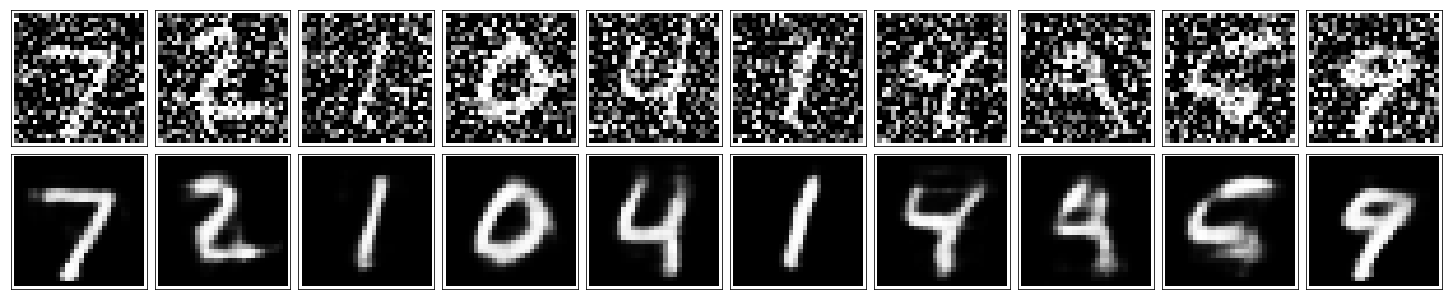

In [18]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = mnist.test.images[:10]
noisy_imgs = in_imgs + noise_factor * np.random.randn(*in_imgs.shape)
noisy_imgs = np.clip(noisy_imgs, 0., 1.)

reconstructed = sess.run(decoded, feed_dict={inputs_: noisy_imgs.reshape((10, 28, 28, 1))})

for images, row in zip([noisy_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

fig.tight_layout(pad=0.1)